In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir("/content/drive/My Drive/ASL Dataset")

In [0]:
train_dir = 'asl_alphabet_train'
test_dir = 'asl_alphabet_test'

In [0]:
def plot_image():
  img_size = 64, 64
  images = []
  labels = []
  for folder in os.listdir(train_dir):
    for file in os.listdir(train_dir + '/' + folder):
      filepath = train_dir + '/' + folder + '/' + file
      image = cv2.imread(filepath)
      final_image = cv2.resize(image, img_size)
      final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)  #Opencv reads in bgr format
      images.append(final_image)
      labels.append(folder)
      break  #we are plotting only one image of each alphabet, from each folder

  return images, labels    

In [6]:
images, labels = plot_image()
print("The labels are : ", labels)

The labels are :  ['X', 'W', 'R', 'Z', 'U', 'V', 'T', 'S', 'space', 'Y', 'O', 'Q', 'J', 'K', 'M', 'I', 'N', 'L', 'nothing', 'P', 'B', 'D', 'G', 'A', 'C', 'F', 'E', 'H', 'del']


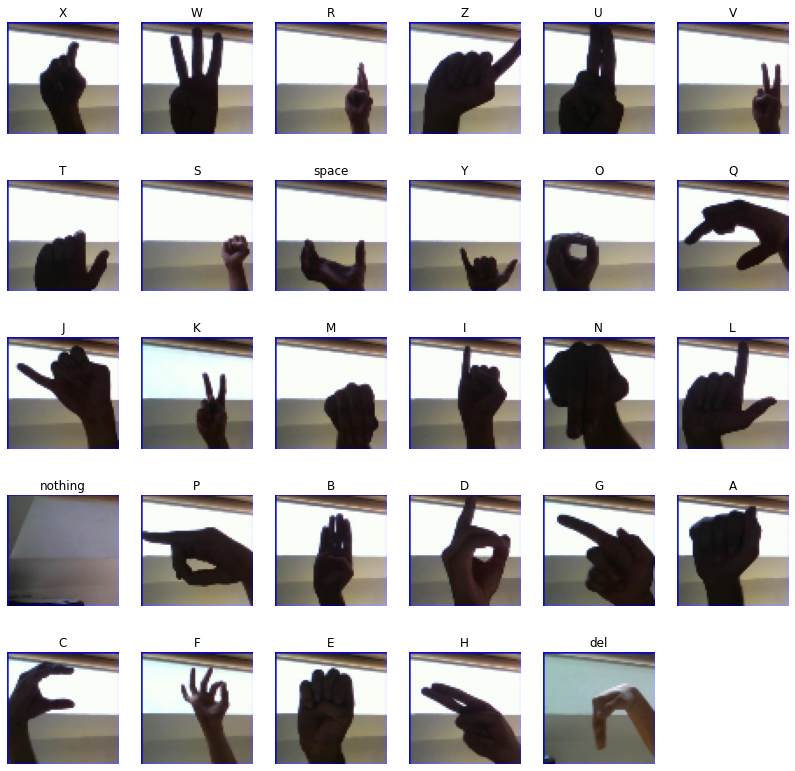

In [8]:
fig = plt.figure(figsize = (14, 14))
def plotter(fig, image, label, rows, cols, index):
  fig.add_subplot(rows, cols, index)
  plt.axis('off')
  plt.imshow(image)
  plt.title(label)
  return

image_index = 0 #starting
rows = 5
cols = 6
for i in range(1, (rows*cols)): 
  plotter(fig, images[image_index], labels[image_index], rows, cols, i)
  image_index += 1
plt.show()   

In [0]:
#Create a mapping from letter to index
label_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}


In [0]:
#Loading the data and preprocessing
#create a test split from train data as the validation split

def load_data():

  images = []
  labels = []
  size = 64, 64
  print("The data is being loaded from : ", end = "")
  for folder in os.listdir(train_dir):
    print(folder, end = ' | ')
    for img in os.listdir(train_dir + '/' + folder):
      image = cv2.imread(train_dir + '/' + folder + '/' + img)
      image = cv2.resize(image, size)
      images.append(image)
      labels.append(label_dict[folder])

  images = np.array(images)
  images = images.astype('float32')   #check if conversion happens
  images = images/255.    

  #labels are 0 - 28, convert to OHE vector

  labels = keras.utils.to_categorical(labels)

  from sklearn.model_selection import train_test_split

  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)

  print("-" * 15)
  print('We have successfully loaded ', len(X_train), 'images for training')
  print('Shape of the train data : ', X_train.shape)

  print("-" * 15)
  print('We have successfully loaded ', len(X_test), 'images for testing')
  print('Shape of the test data : ', X_test.shape)

  return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = load_data()

The data is being loaded from : X | W | R | Z | U | V | T | S | space | Y | O | Q | J | K | M | I | N | L | nothing | P | B | D | G | A | C | F | E | H | del | ---------------
We have successfully loaded  78318 images for training
Shape of the train data :  (78318, 64, 64, 3)
---------------
We have successfully loaded  8702 images for testing
Shape of the test data :  (8702, 64, 64, 3)


In [0]:
def final_model():

  model = Sequential()

  model.add(Conv2D(16, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (64, 64, 3)))
  model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (3, 3)))

  model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (3, 3)))

  model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (3, 3)))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(units = 512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
  model.add(Dense(units = 29, activation = 'softmax'))

  model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])

  model.summary()

  return model

In [0]:
def model_fitting(model):
  history = model.fit(X_train, y_train,
                      batch_size = 64,
                      epochs = 6,
                      validation_split = 0.1)
  return history

In [17]:
model = final_model()
model_hist = model_fitting(model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)        

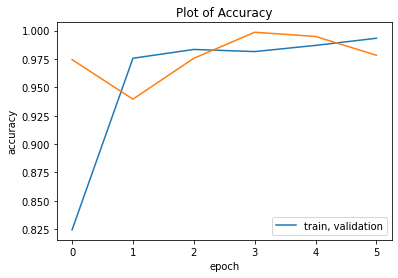

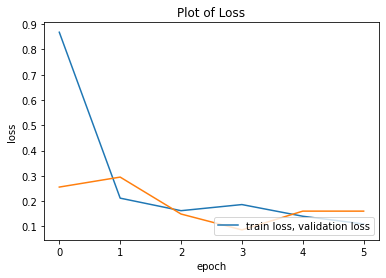

In [20]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.legend(['train, validation'], loc = 'lower right')
plt.title('Plot of Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.legend(['train loss, validation loss'], loc = 'lower right')
plt.title('Plot of Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()



In [0]:
#Now we test the model on the unseen dataset

In [23]:
eval_loss, eval_accuracy = model.evaluate(X_test, y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(eval_accuracy * 100))
print("\nEvaluation Loss = ", "{:.5f}".format(eval_loss))

8702/8702 [==============================] - 1s 117us/step

Evaluation Accuracy =  97.72%

Evaluation Loss =  0.16033


In [0]:
#after evaluation of the test data results, lets visualize some of the predictions
#We load the test images and print the image name which shows the class, and print the model prediction
def test_loader():
  images = []
  names = []
  size = 64, 64
  for image in os.listdir(test_dir):
    img = cv2.imread(test_dir + '/' + image)
    img = cv2.resize(img, size)
    images.append(img)
    names.append(image)

  images = np.array(images)
  images = images.astype('float32')
  images = images / 255. 

  return images, names

test_images, test_image_names = test_loader()   


In [0]:
#Predictions
predictions = [model.predict_classes(image.reshape(1, 64, 64, 3))[0] for image in test_images]

In [0]:
def labels_for_plot(predictions):
  prediction_labels = []  #This will contain elements liks [A] etc, predictions array holds classes as a number (index)

  for i in range(len(predictions)):
    for indice in label_dict:
      if predictions[i] == label_dict[indice]:
        prediction_labels.append(indice)
        break
  return prediction_labels

pred_labels = labels_for_plot(predictions)        

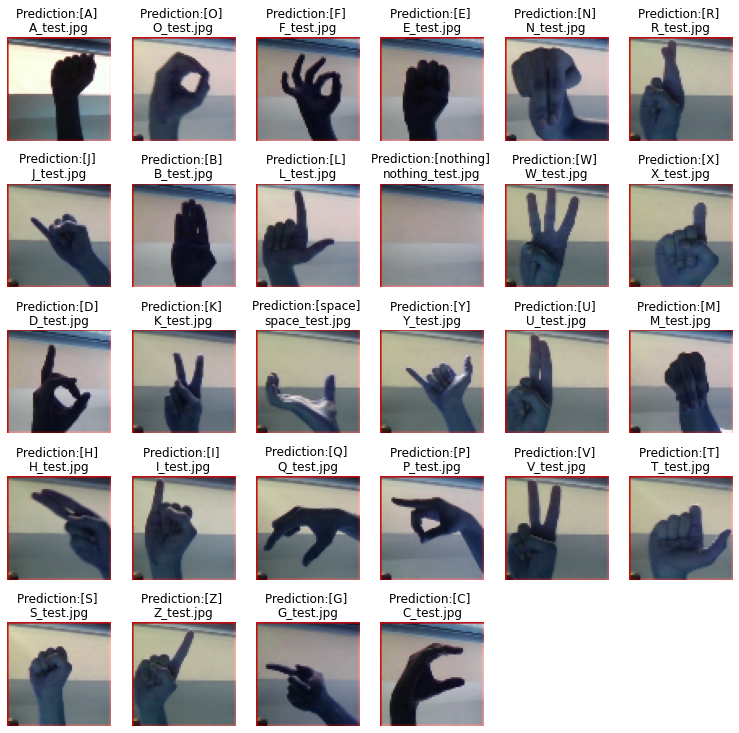

In [63]:
prediction_figure = plt.figure(figsize = (13, 13))
def plot_final_predictions(fig, image, label, prediction, prediction_label, rows, cols, index):
  fig.add_subplot(rows, cols, index)
  plt.axis('off')
  plt.imshow(image)
  title = "Prediction:["+ str(prediction_label) + "] " + "\n" + label
  plt.title(title)
  return

image_index = 0
rows = 5
cols = 6
for index in range(1, (rows * cols - 1)):
  plot_final_predictions(prediction_figure, test_images[image_index], test_image_names[image_index], predictions[image_index], pred_labels[image_index], rows, cols, index)

  image_index += 1
plt.show()      